# TP 2 : Computer Vision

## Part 1 : segmentation

In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

(800, 586)

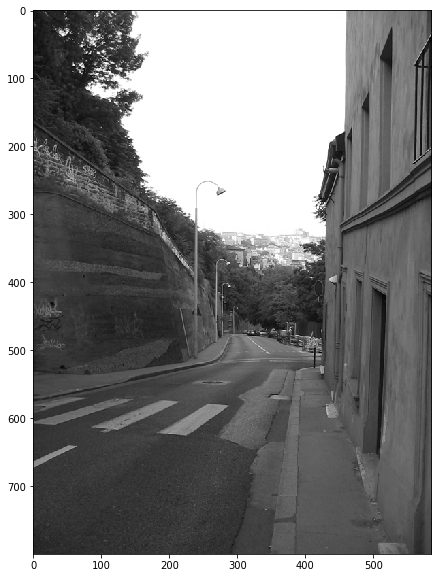

In [11]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color


import warnings
warnings.filterwarnings('ignore')

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and 

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and 

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions : you cannot have a region with no pixels. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [12]:
# This function returns the segmentation of the algorithm of otsu, as well as the threshold found
def segmentation_otsu(img):

        # FILL IN CODE HERE
    # "
      I = img.copy()
      list_tau = np.linspace(0, 1, 256)
      tau_out = list_tau[0]

      I_0 = I[I<=tau_out]
      I_1 = I[I>tau_out]
      f_out = np.size(I_0)*np.var(I_0) + np.size(I_1)*np.var(I_1)

      seg_otsu = np.zeros(I.shape)
      seg_otsu[I>tau_out] = 1

      for tau in list_tau[1:]:
        I_0 = I[I<=tau]
        I_1 = I[I>tau]
        f = np.size(I_0)*np.var(I_0) + np.size(I_1)*np.var(I_1)
        if f < f_out:
          tau_out = tau
          f_out = f
          seg_otsu = np.zeros(np.shape(I))
          seg_otsu[I>tau_out] = 1
        # "
      return seg_otsu,tau_out

Carry out the segmentation on the input image and display the result

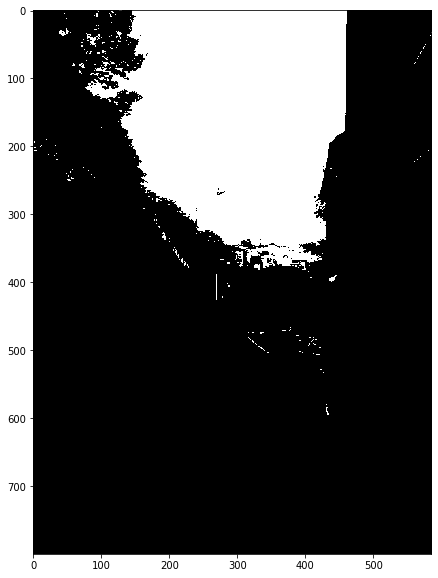

In [13]:
img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

__Question__ What problem can you see with the segmentation result ? What morphological technique(s) (seen in the lesson) could you use to clean the result up ? 

<font color="blue">__Answer__:</font>

> -  The problem with the segmentation result is that different parts are not homogeneous (white pixels are found in the black parts vice versa). To solve this, we could use opening and closing of morphological techniques.

Carry out this technique to clean up the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

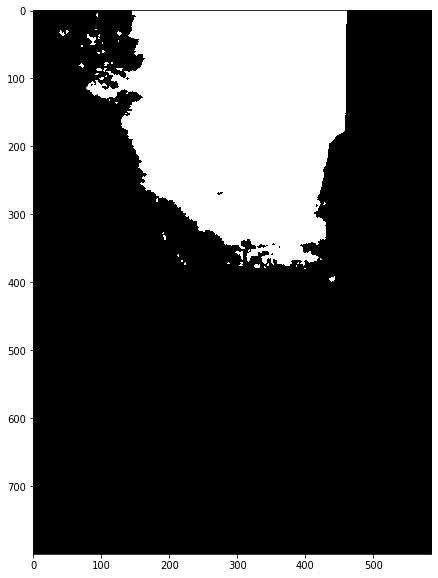

In [14]:
from skimage.morphology import opening, closing

struct_size = 7
struct_el = np.ones((struct_size,struct_size))
img_out_otsu_cleaned = closing(opening(img_out_otsu)) # FILL IN CODE HERE

display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

__Question__ In which order did you propose to carry out the morphological operations ? Why ?

<font color="blue">__Answer__:</font>

> - We fisrt propose opening method because, the problem of white pixels in the black regions was important( there were more white pixels in the dark regions) and they had to disapar first. And if we had done the closing first, they would have been linked to each other which would lead to block of white pixels in the dark regions.

Le problème avec le résultat de la segmentation est que les parties ne sont pas homogènes (pixels blancs dans la partie noire et pixels noirs dans la partie blanche). Pour remédier à ce problème nous pourrions utiliser des techniques d'opening ou de closing.

Let's change the image, and carry out the segmentation again.

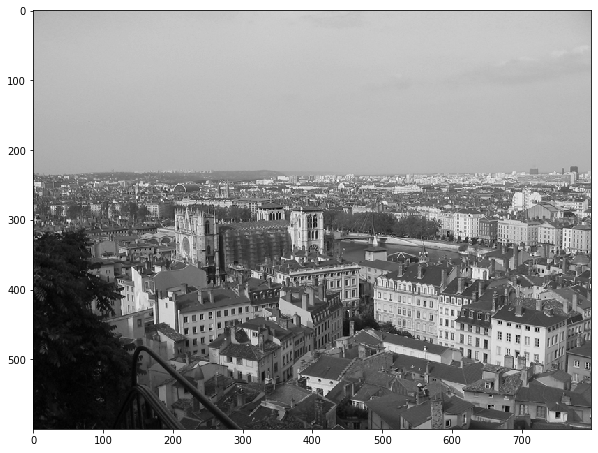

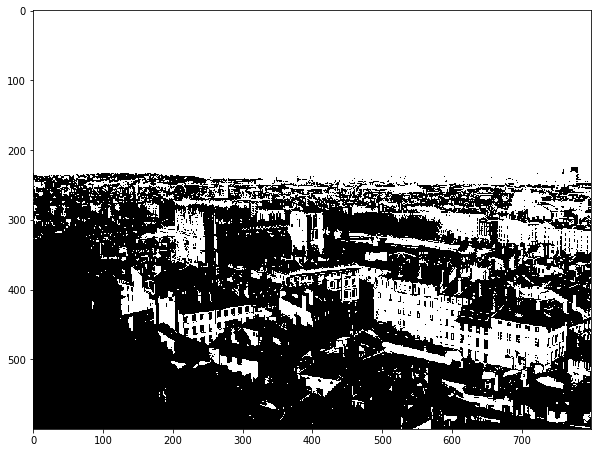

In [15]:
file_name = 'town'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

As we can see, there is no notion of connectivity in the algorithm of Otsu (two regions far away can be in the same segment). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add new pixels progressively to the region. More precisely, at each iteration of the algorithm, we attempt to add the neighbours of the pixels in the current segmentation. We add new pixels according to the criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [16]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    # FILL IN CODE HERE
    img = np.ones(img_shape)
    img[seed_pt[0], seed_pt[1]] = 0
    seg_init = distance_transform_edt(img)
    return seg_init 

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

__IMPORTANT NOTE__ Once a pixel has been added to the region, it is in the region permanently : it is not checked again in further iterations (otherwise we could remove pixels which were added).

In [17]:
from scipy.ndimage import binary_dilation

# This function returns both the final segmentation and the initialisation
def segmentation_region_growing(img,seed_pt,tau):
    
    # FILL IN CODE HERE
    #"
    sg_init = initialize_segmentation(seed_pt,np.shape(img))
    sg = sg_init.copy()
    avg = np.average(img[sg == 1])
    while True:
      seg_nbhd = binary_dilation(sg) & (sg == 0)
    # "
      pixels_to_add = seg_nbhd & (np.abs(img - avg) < tau)
     #
      if not np.any(pixels_to_add):
        break
      sg[pixels_to_add] = 1
    #
      avg = np.average(img[sg == 1])
    # "
    return sg, sg_init

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

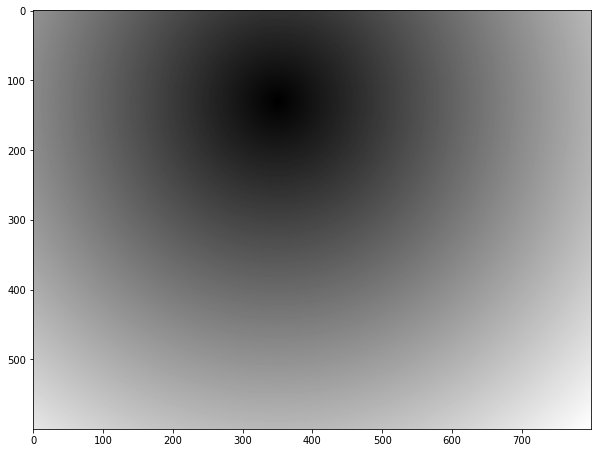

In [18]:
seed_pt = np.asarray([130,350])
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)
display_image(img_out_region_growing)
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')